# Testing the Method on SANS-2D Data

## EMTK Object Oriented API Analysis

An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


EMAnalyser object created with 6073261 weighted events in range 0.010000018765608024 - 0.5941878658588073


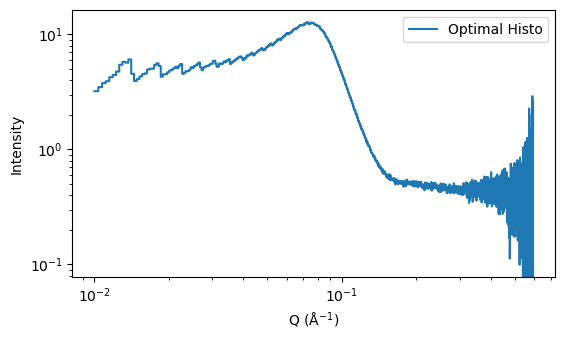

In [23]:
import numpy as np
import scipp as sc
import sciline
import scippneutron as scn
import plopp as pp
from ess import sans
from ess import isissans as isis
from ess.sans.types import *

from tqdm import tqdm


import matplotlib.pyplot as plt

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, this lets us change the source and force reload
# However, whilst the error reporting line number is right, the printout of
# the offending source is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def getWeightedSans2DEvents():
    """ Performs a super-lean version of the whole of the 
        above scipp data processing in one function.
    Returns:
        evs: numpy array of event Q values
        wts: numpy array of event weights
    """

    params = {}

    params[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.dat'
    params[Filename[SampleRun]] = 'SANS2D00063114.nxs'
    params[Filename[BackgroundRun]] = 'SANS2D00063159.nxs'
    params[Filename[EmptyBeamRun]] = 'SANS2D00063091.nxs'
    params[OutFilename] = 'reduced.nxs'

    params[NeXusMonitorName[Incident]] = 'monitor2'
    params[NeXusMonitorName[Transmission]] = 'monitor4'

    params[isis.SampleOffset] = sc.vector([0.0, 0.0, 0.053], unit='m')
    params[isis.MonitorOffset[Transmission]] = sc.vector([0.0, 0.0, -6.719], unit='m')

    params[WavelengthBins] = sc.linspace(
        'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
    )
    
    params[isis.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')
    
    mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
    params[WavelengthMask] = sc.DataArray(
        sc.array(dims=['wavelength'], values=[True]),
        coords={'wavelength': mask_interval},
    )
    
    params[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
    params[NonBackgroundWavelengthRange] = sc.array(
        dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
    )
    params[CorrectForGravity] = True
    params[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
    params[ReturnEvents] = True

    providers = (
        sans.providers + isis.providers + isis.data.providers + isis.sans2d.providers
    )
    providers = providers + (
        isis.data.transmission_from_background_run,
        isis.data.transmission_from_sample_run,
        sans.beam_center_from_center_of_mass,
    )

    pipeline = sciline.Pipeline(providers=providers, params=params)

    ### Old Code...
#    pipeline = sciline.Pipeline(
#    sans.providers + isis.sans2d.providers,
#    params=sans.sans2d.default_parameters,
#    )

#    pipeline[FileList[BackgroundRun]] = ['SANS2D00063159.hdf5']
#    pipeline.insert(sans.transmission_from_background_run)
#    pipeline[FileList[SampleRun]] = ['SANS2D00063114.hdf5']
#    pipeline.insert(sans.transmission_from_sample_run)
#    pipeline[FileList[EmptyBeamRun]] = ['SANS2D00063091.hdf5']
#    pipeline[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.hdf5'
#    pipeline[OutFilename] = 'reduced.nxs'
    
#    pipeline[WavelengthBins] = sc.linspace(
#        'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
#    )
    
#    pipeline[sans.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')
    
#    mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
#    pipeline[WavelengthMask] = sc.DataArray(
#        sc.array(dims=['wavelength'], values=[True]),
#        coords={'wavelength': mask_interval},
#    )
    
#    pipeline[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
#    pipeline[NonBackgroundWavelengthRange] = sc.array(
#        dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
#    )
#    pipeline[CorrectForGravity] = True
#    pipeline[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
#    pipeline[sans.ReturnEvents] = True
    ### End of old code...






    

    siq = pipeline.get(IofQ[SampleRun])
    sres= siq.compute()
    
    allsevents = sres.bins.concat().value


    seventQ = allsevents.coords['Q'].values
    seventW = allsevents.values
        
    nans = np.isnan(seventW)
    seventW[nans] = 0.0
    msk = np.where(seventW < 0.0)
    seventW[msk] = 0.0

    return seventQ, seventW







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def cauchy_cubed_integral(x1, x2, kappa):
    # Returns the integral of a cauchy-cubed distribution between two x values
    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    denom = 8.0 * np.pi**3.0 * kappa**2.0
    
    t1 = kappa * (3.0 * xmax**3.0 + 5.0 * xmax * kappa**2.0) / ( xmax**2.0 + kappa**2.0)**2.0
    t2 = kappa * (3.0 * xmin**3.0 + 5.0 * xmin * kappa**2.0) / (xmin**2.0 + kappa**2.0)**2.0
    t3 = 3.0 * np.arctan(xmax / kappa)
    t4 = 3.0 * np.arctan(xmin / kappa)

    result = (-t1 + t2 -t3 + t4)/denom
    
    
    return np.absolute(result)
    


def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    intg = norm.cdf(x1, loc=mu, scale=sigma) - norm.cdf(x2, loc=mu, scale=sigma)
    
    return np.absolute(intg)




evs, wts = getWeightedSans2DEvents()

ema1 = ema.EMAnalyser(evs, wts)

ema1.plot_histogram()
#ema1.plot_kde()

In [2]:
ema1.help()

The analyser object is created with a numpy array of events
(x-values) and their weights:


            import emtk.EventModeAnalyser.EMAnalyser as ema
            ema1 = ema.EMAnalyser(events, weights)

There are two provided workflows with the same API.  The first API
does regular histogram and least squares fit analysis with lmfit as a
backend.  So you need to define a function and parameters, exactly
according to lmfit documentation, which are passed through to lmfit.
These include:

            set_lse_function()
            make_lse_params()
            lse_fit()

And to get the results of those fits:
            plot_LSE_fit()
            get_lse_param_values()
            get_lse_param_sigmas()
            get_lse_param_names()

The last one takes the names as specified in the lmfit interface to
make the parameters, as passed to the function above.

The main event mode analysis part is a Markov-Chain Monte-Carlo
sampling method using emcee as a backend.  If you want to subsampl

Least squares model function defined.


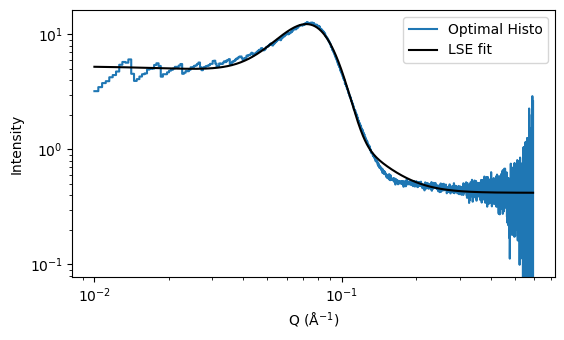

['amplitude', 'kappaSample', 'sigma', 'q0', 'kappaBG', 'm1', 'm2', 'm3']
[9.99260870e-01 1.22310839e-01 1.81068888e-02 7.33329300e-02
 7.59894147e-02 3.04083096e-01 1.82471083e-09 4.50437296e-01]
[3.77722162e-03 9.88833479e-03 1.70494396e-04 1.39505619e-04
 1.82204799e+07 9.17110234e-02 1.45589624e-01 8.62836278e-03]


In [24]:
def big_lse_pdf(x, amplitude, kappaSample, sigma, q0, kappaBG, m1, m2, m3):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3]))

    lor3 = mvals[0] * cauchy.pdf(x, scale=kappaSample, loc=0.0)**3.0 / cauchy_cubed_integral(ema1.xmin, ema1.xmax,kappaSample)
    lorbg= mvals[1] * cauchy.pdf(x, scale=kappaBG, loc=0.0)/cauchy_integral(ema1.xmin, ema1.xmax, kappaBG)
    gauss= mvals[2] * norm.pdf(x, scale=sigma, loc=q0) / gaussian_integral(ema1.xmin,ema1.xmax, q0, sigma)
    flt =  mvals[3] / uniform_integral(ema1.xmin, ema1.xmax)

    sol = amplitude *( lor3 + lorbg + gauss + flt)
    
    return sol


ema1.set_lse_function(big_lse_pdf)

ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    kappaSample=dict(value=0.05, min=0.001, max=1.0),\
    sigma=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),\
    kappaBG=dict(value=0.05, min=0.001, max=1.0),\
    m1=dict(value=0.1, min=0.0, max = 1.0),\
    m2=dict(value=0.1, min=0.0, max = 1.0),\
    m3=dict(value=0.1, min=0.0, max = 1.0)
)

ema1.lse_fit()
ema1.plot_LSE_fit()

pvals = ema1.get_lse_param_values()
psigs = ema1.get_lse_param_sigmas()
pnams = ema1.get_lse_param_names()

print(pnams)
print(pvals)
print(psigs)

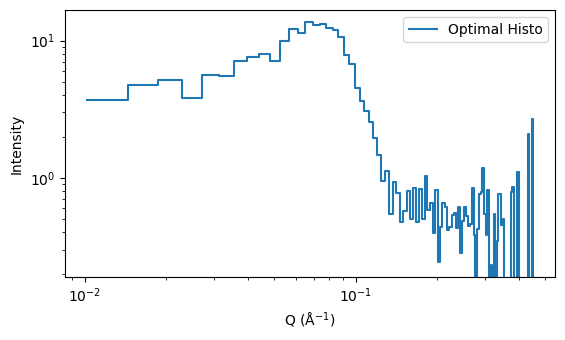

Calculating KDE


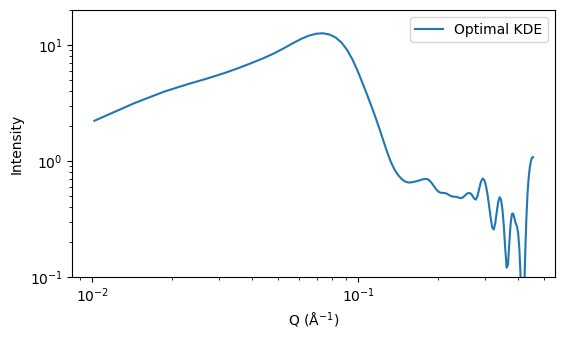

In [31]:
cpo = ema1.subsample(4000)
cpo.plot_histogram()
cpo.plot_kde([0.1,20])

In [41]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
        
    if 0.001 < kappaSample < 1.0 and\
    0.01 < sigma < 0.1 and\
    0.001 < q0 < 0.1 and\
    0.001 < kappaBG < 1.0 and\
    0.1 < m1 < 1.0 and\
    0.1 < m2 < 1.0 and\
    0.1 < m3 < 1.0 and\
    m1 + m2 + m3 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin

    
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    
    
    signal = cauchy.pdf(xx, loc=0.0, scale = kappaSample)**3.0
    background = cauchy.pdf(xx, loc=0.0, scale = kappaBG)
    gauss = norm.pdf(xx, loc=q0, scale = sigma)
    unif = uniform.pdf(xx, loc=xmin, scale = xmax)
    
    term1 = mvals[0] * signal / sig_int
    term2 = mvals[1] * background / bg_int
    term3 = mvals[2] * gauss / gauss_int
    term4 = mvals[3] * 1.0 / uniform_int
    
            
    if verbose:
        print("xmin:", self.xmin)
        print("xmax:", self.xmax)
        print("Signal:", signal)
        print("Background:", background)
        print("Gauss:", gauss)
        print("Gauss:", gauss)
        print("sig_int:", sig_int)
        print("bg_int:", bg_int)
        print("mvals:", mvals)
    
    result = (term1 + term2 + term3 + term4)**use_weights
    
    return result




def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    

    signal = mvals[0]*cauchy.pdf(data, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = mvals[1]*cauchy.pdf(data, loc=0.0, scale = kappaBG) / bg_int
    gauss = mvals[2]*norm.pdf(data, loc=q0, scale = sigma) / gauss_int
    unif = mvals[3] / uniform_int

    # Guard against zero values in each term
    minval = 1.0E-300

    msk = signal < minval
    signal[msk] = minval

    msk = background < minval
    background[msk] = minval

    msk = gauss < minval
    gauss[msk] = minval

    if unif < minval:
        unif = minval


    ll = np.log(signal)
    lbg = np.log(background)
    lgauss = np.log(gauss)
    lunif = np.log(unif)

    # logaddexp is used to add the two components in linear space
    # in theory I suppose you can do it before taking the log above...
    ll1 = np.logaddexp(ll, lbg)
    ll2 = np.logaddexp(ll1, lunif)
    ll3 = np.logaddexp(ll2, lgauss)
    ll4 = np.sum(ll3 * use_weights)
        
    result = lp + ll4
    
    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        if verbose:
            print("mvals", mvals)
            print("signal", signal)
            print("background", background)
            print("gauss", gauss)
            print("uniform", unif)
            print("sig_int", sig_int)
            print("bg_int", bg_int)
            print("gauss_int", gauss_int)
            print("uniform_int", uniform_int)
        
    return result


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
cpo.theta_seed = np.array([0.11610878745187037,\
                           0.018766787799024232,\
                           0.0719479371044884,\
                           0.999998495793329,\
                           0.275896153469968,\
                           0.3460716482480896,\
                           0.49294212343714894])

same_as_lse = np.array([0.05, 0.05, 0.07, 0.05, 0.1, 0.1, 0.1])

something_in_between =\
    np.array([0.08, 0.015, 0.07, 0.8, 0.35, 0.35, 0.35])

cpo.theta_seed = something_in_between

# Seed MCMC search with LSE fit
cpo.lse_fit()
#cpo.theta_seed = cpo.get_lse_param_values()
#cpo.theta_seed = cpo.theta_seed[1:]


def exmax_fit(theta0, events, weights, niter=200, minimum_delta = 1E-06):
    # Test expectation maximisation 

    kappaSample, sigma, q0, kappaBG = theta0
    
    categories = np.zeros_like(events, dtype=np.integer)

    xmin = np.amin(events)
    xmax = np.amax(events)

    # Initial pass computing the maximum likelihood of the categories
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)
    
    signal = cauchy.pdf(events, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = cauchy.pdf(events, loc=0.0, scale = kappaBG) / bg_int
    gauss = norm.pdf(events, loc=q0, scale = sigma) / gauss_int
    unif = np.ones_like(events) / uniform_int

    # stack these event-by-event PDFs up into a grid
    catgrid = np.stack((signal, background))
    catgrid = np.vstack((catgrid, gauss))
    catgrid = np.vstack((catgrid, unif))

    # Find the maximum index as the intial maximum likelihood categorisation
    # on an event-by-event basis
    categories = np.argmax(catgrid, axis=0)

    # Note: in the main loop, each category will be computed point by point holding
    # everything else constant, so this code isn't duplicated below exactly.

    iteration = 0


    def loglikelihood(theta, cat):

        kappaSample, sigma, q0, kappaBG = theta

        # set up category-dependent weighting parameters
        cat0 = cat == 0
        cat1 = cat == 1
        cat2 = cat == 2
        cat3 = cat == 3

        w0 = np.zeros_like(events)
        w1 = np.zeros_like(events)
        w2 = np.zeros_like(events)
        w3 = np.zeros_like(events)

        w0[cat0] = 1.0
        w1[cat1] = 1.0
        w2[cat2] = 1.0
        w3[cat3] = 1.0

        
        sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
        bg_int = cauchy_integral(xmin, xmax, kappaBG)
        gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
        uniform_int = uniform_integral(xmin, xmax)

        signal = w0 * cauchy.pdf(events, loc=0.0, scale = kappaSample)**3.0 / sig_int
        background = w1 * cauchy.pdf(events, loc=0.0, scale = kappaBG) / bg_int
        gauss = w2 * norm.pdf(events, loc=q0, scale = sigma) / gauss_int
        unif = w3 * np.ones_like(events) / uniform_int

        # Drop the zeros
        minval = 1.0E-300
        msk = signal < minval
        signal[msk] = minval

        msk = background < minval
        background[msk] = minval

        msk = gauss < minval
        gauss[msk] = minval

        msk = unif < minval
        unif[msk] = minval


        lsig = weights * np.log(signal)
        lbg = weights * np.log(background)
        lg = weights * np.log(gauss)
        lu = weights * np.log(unif)

        ll = lsig + lbg + lg + lu

        llsum = np.sum(ll)

        return(llsum)

        print(x0)


    
    
    def dloglikelihood(theta, cat):

        th0 = np.array(list(theta))
        dydp = np.zeros_like(th0)

        for ii in range(len(dydp)):
            p0 = th0[ii]
            if p0 == 0.0:
                p1 = 0.0001
                p2 = -0.0001
            else:
                p1 = p0 + p0/1000.0
                p2 = p0 - p0/1000.0

            dp1 = p1 - p0
            dp2 = p0 - p2

            parray1 = np.array(th0) # looks like python is a bit like ruby
            parray2 = np.array(th0) # you have to actually duplicate the objects
            parray1[ii] = p1
            parray2[ii] = p2

            yzero = loglikelihood(tuple(th0), cat)
            yone = loglikelihood(tuple(parray1), cat)
            ytwo = loglikelihood(tuple(parray2), cat)

            dy1 = yone-yzero
            dy2 = yzero-ytwo

            dy = 0.5*(dy1 + dy2)
            dp = 0.5*(dp1 + dp2) # probably it must always be that dp1 = dp2, but best be careful

            dydp[ii] = dy/dp

        return dydp


    def ddloglikelihood(theta, cat):

        th0 = np.array(list(theta))
        dydp = np.zeros_like(th0)

        for ii in range(len(dydp)):
            p0 = th0[ii]
            if p0 == 0.0:
                p1 = 0.0001
                p2 = -0.0001
            else:
                p1 = p0 + p0/1000.0
                p2 = p0 - p0/1000.0

            dp1 = p1 - p0
            dp2 = p0 - p2

            parray1 = np.array(th0) # looks like python is a bit like ruby
            parray2 = np.array(th0) # you have to actually duplicate the objects
            parray1[ii] = p1
            parray2[ii] = p2

            yzero = dloglikelihood(tuple(th0), cat)[ii]
            yone = dloglikelihood(tuple(parray1), cat)[ii]
            ytwo = dloglikelihood(tuple(parray2), cat)[ii]

            dy1 = yone-yzero
            dy2 = yzero-ytwo

            dy = 0.5*(dy1 + dy2)
            dp = 0.5*(dp1 + dp2) # probably it must always be that dp1 = dp2, but best be careful

            dydp[ii] = dy/dp

        return dydp

    iteration = 0
    
    while iteration < 50:

        # Newton iterate the parameters once in the direction to maximise the log-likelihood

        print("Maximum likelihood stage")

        theta = kappaSample, sigma, q0, kappaBG    

        oldvals = np.array(theta)
        
        dy = dloglikelihood(theta, categories)
        ddy = ddloglikelihood(theta, categories)
        newvals = oldvals - dy / ddy
        pchange = newvals - oldvals

        kappaSample, sigma, q0, kappaBG = tuple(newvals)
        
        # Recompute the maximum likelihood categorisation event-by-event

        newcategories = np.array(categories)

        print("Recomputing categories")        
        for ii in tqdm(range(len(events))): 
            llcat = np.zeros(4)

            for jj in range(0, 4):
                testcat = np.array(categories)
                testcat[ii] = jj
                llcat[jj] = loglikelihood(theta, testcat)

            bestcat = np.argmax(llcat)

            newcategories[ii] = bestcat

        categories = newcategories

        print(newvals)

        iteration = iteration + 1
        
        if(pchange.all() < 1.0E-06):
            break

    print(newvals)
    return newvals, categories


#cpo.MCMC_fit(nburn=50, niter=200)
#cpo.MCMC_fit(niter=10000, convergence="Gelman-Rubin")

shortTheta = np.array([0.08, 0.015, 0.07, 0.08])

pars, cats = exmax_fit(shortTheta, cpo.data, cpo.weights)
                               

Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 598.90it/s]


[0.04086495 0.01313245 0.0736556  0.10907268]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 594.95it/s]


[0.0519615  0.01307277 0.07365561 0.12772173]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 594.10it/s]


[0.05369392 0.01299438 0.07399839 0.09155606]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 596.70it/s]


[0.06022269 0.01289035 0.07413375 0.1216498 ]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:07<00:00, 550.68it/s]


[0.06257341 0.01284117 0.07436782 0.13508799]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 576.95it/s]


[0.06407738 0.01259133 0.0746427  0.14431823]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 588.63it/s]


[0.06464486 0.01258964 0.07483828 0.14885695]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 589.92it/s]


[0.06562531 0.01243096 0.07505677 0.15234046]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 588.79it/s]


[0.06605416 0.01243157 0.07522199 0.15400705]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 588.95it/s]


[0.06654657 0.01235457 0.07533011 0.15452568]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 589.43it/s]


[0.06668799 0.01239124 0.07543116 0.15573089]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 586.92it/s]


[0.0669992  0.01234135 0.07549632 0.15566715]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 588.69it/s]


[0.06704667 0.01237635 0.07555904 0.15655156]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 584.57it/s]


[0.06735618 0.01232705 0.07562399 0.15647768]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 587.98it/s]


[0.06735895 0.01236141 0.0756676  0.15709444]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 586.43it/s]


[0.06766668 0.01231929 0.07574127 0.15709919]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 587.27it/s]


[0.06766941 0.01233315 0.07575875 0.15746972]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 586.39it/s]


[0.06806018 0.01227826 0.07585378 0.15747142]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 586.97it/s]


[0.06806458 0.0122785  0.07585378 0.15767254]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 587.14it/s]


[0.0682817  0.01224813 0.07590653 0.15767304]
Maximum likelihood stage
Recomputing categories


100%|██████████████████████████████████████| 4000/4000 [00:06<00:00, 583.27it/s]

[0.06828304 0.0122482  0.07590653 0.15767304]
[0.06828304 0.0122482  0.07590653 0.15767304]


In [48]:
def pmf(xx, theta, cat, weights):
    kappaSample, sigma, q0, kappaBG = theta

    xmin = np.amin(xx)
    xmax = np.amax(xx)

    cat0 = cat == 0
    cat1 = cat == 1
    cat2 = cat == 2
    cat3 = cat == 3

    w0 = np.zeros_like(cat)
    w1 = np.zeros_like(cat)
    w2 = np.zeros_like(cat)
    w3 = np.zeros_like(cat)

    w0[cat0] = 1.0
    w1[cat1] = 1.0
    w2[cat2] = 1.0
    w3[cat3] = 1.0

    w0 = np.sum(w0 * weights)
    w1 = np.sum(w1 * weights)
    w2 = np.sum(w2 * weights)
    w3 = np.sum(w3 * weights)

    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    signal = w0 * cauchy.pdf(xx, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = w1 * cauchy.pdf(xx, loc=0.0, scale = kappaBG) / bg_int
    gauss = w2 * norm.pdf(xx, loc=q0, scale = sigma) / gauss_int
    unif = w3 * np.ones_like(xx) / uniform_int

    result = signal + background + gauss + unif

    return(result)


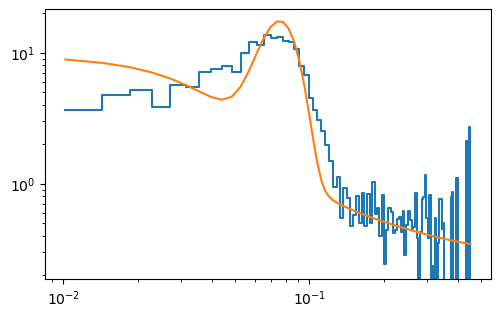

In [50]:
solution_theta = tuple(pars)

yfit = pmf(cpo.histx, solution_theta, cats, cpo.weights)

ysum = np.sum(yfit)
dsum = np.sum(cpo.histy)
scale = dsum / ysum

plt.step(cpo.histx, cpo.histy, where='post')
plt.plot(cpo.histx, scale * yfit)
plt.yscale('log')
plt.xscale('log')

(200, 32, 7)
(200, 32, 7)


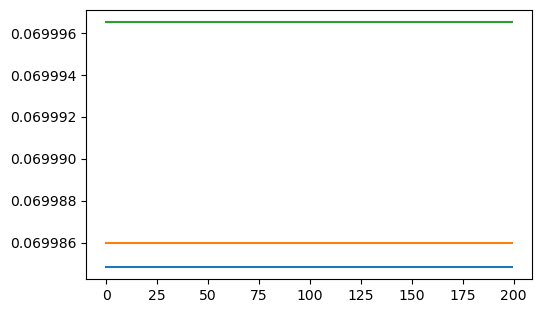

In [45]:
chz = cpo.sampler.get_chain()
nwk = cpo.nwalkers
ndm = cpo.ndim

rlen = chz.shape[0]

print(chz.shape)

burned = chz[-500::]
#=np.delete(chz, np.s_[rlen-42:rlen], axis=0)
print(burned.shape)
ch1 = burned[:,1,2]
ch2 = burned[:,2,2]
ch3 = burned[:,3,2]
fig,ax=plt.subplots()
ax.plot(ch1)
ax.plot(ch2)
ax.plot(ch3)

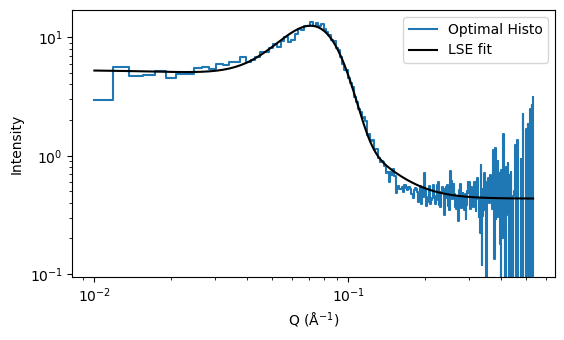

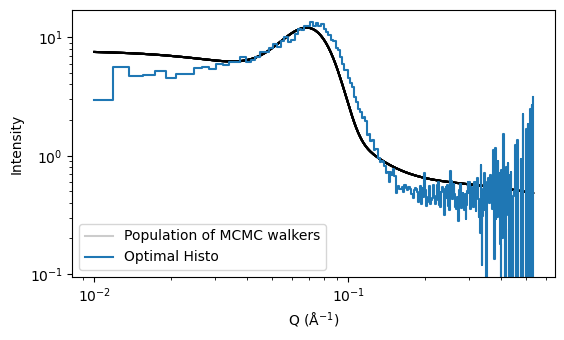

Calculating KDE


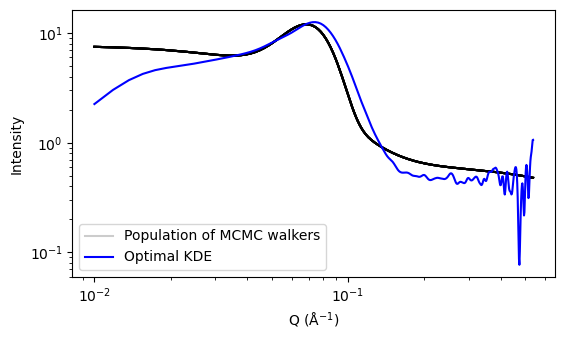

In [46]:
cpo.plot_LSE_fit()
cpo.plot_MCMC_fit(method="histo")
cpo.plot_MCMC_fit(method="kde")


You can clearly see that the fit is better with MCMC even on the histogram.  The KDE is still not right though.

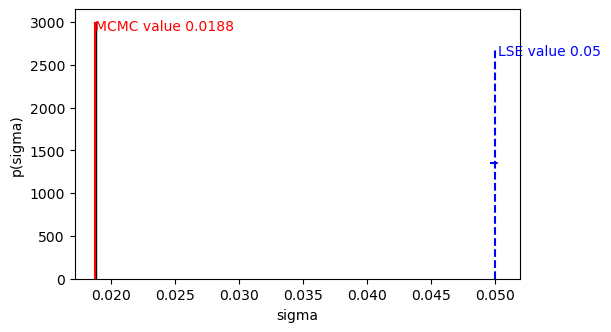

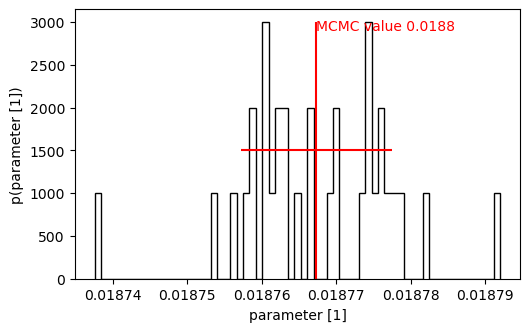

In [18]:
lookat=1
cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False)

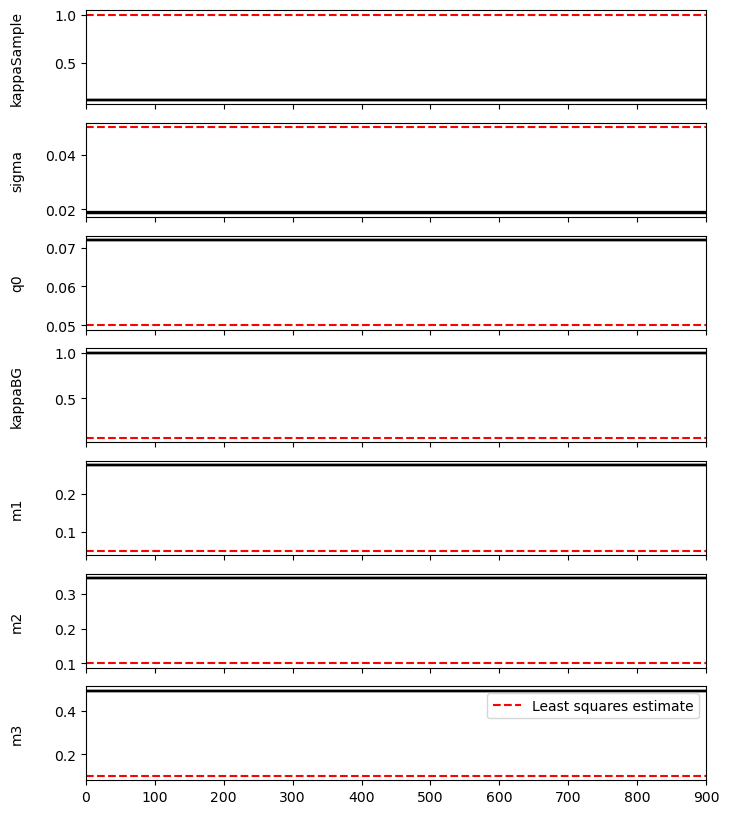

In [19]:
cpo.plot_MCMC_convergences()

In [20]:
pvals, psigs = cpo.get_MCMC_parameters()
pnams = cpo.get_lse_param_names()

for i in range(0, pvals.size):
    print(pnams[i], pvals[i], psigs[i])

amplitude 0.11611057354008994 5.09898296296383e-08
kappaSample 0.01876733118383973 5.647246722811976e-08
sigma 0.07195123301625168 5.314697895517647e-08
q0 0.9999980048357027 5.1848364582319765e-08
kappaBG 0.2758956447375971 5.414722952968501e-08
m1 0.3460712325820972 4.756876227138642e-08
m2 0.49294282728440014 6.158942160609767e-08
